In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import shap

import math

from lib import *

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
# plt.style.use('dark_background')
sns.set_theme(style="whitegrid", palette="muted")
sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

Загрузим и подготовим данные

In [189]:
WORK_DIR = 'working_data'
FILE_NAME = 'df_work_ds_final.zip'

In [190]:
filepath = Path(f'./{WORK_DIR}/{FILE_NAME}')
df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [191]:
columns_drop = [
    "Fel_1",
    "Fel_2",
    "D_SL",
    "O2_tot",
    "Sl_tot",
    "AC_rbk_open",
    "AC_valve_open",
    "P_O2_in",
    "P_tot_2",
    "FT1_level",
    "FT1_P",
    "FT1_T_in",
    "FT1_T",
    "FT2_level",
    "FT2_P",
    "FT2_T",
    "Cond_Q",
    "Cond_level",
    "Cond_valve",
    "O2_conc_1",
    "O2_conc_2",
    'T_C1',
    'T_C2',
    'T_C3',
    'T_C4',
    'T_C5'
]

df.drop(columns_drop, inplace=True, axis=1)

In [192]:
for col in df.columns:
    smooth_data_moving_average(df[col], window=12)

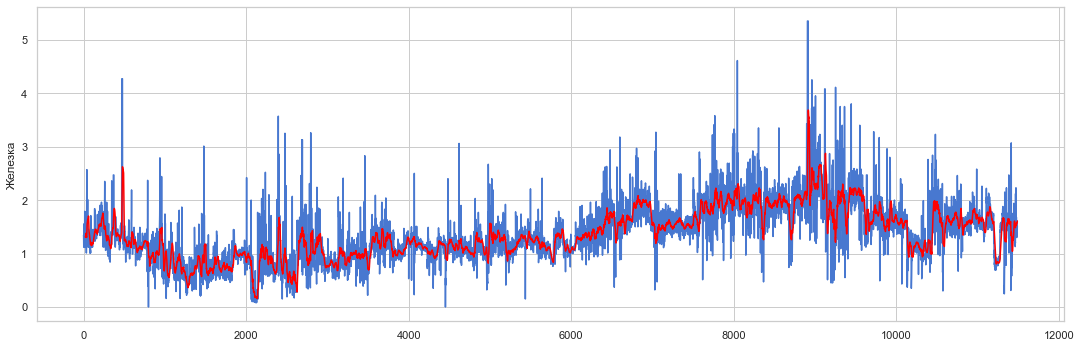

In [194]:
plot_data_rolling(df['Fe2+'], title='Железка', rolling=True)

In [124]:
df['Fe2+_corr'] = df['Fe2+'].shift(2)

df.dropna(axis=0, inplace=True)

df['lag_1'] = df['Fe2+_corr'].shift(1)
df['lag_2'] = df['Fe2+_corr'].shift(2)
df['lag_3'] = df['Fe2+_corr'].shift(3)
df['lag_4'] = df['Fe2+_corr'].shift(4)
df['lag_5'] = df['Fe2+_corr'].shift(5)

df.dropna(axis=0, inplace=True)

In [125]:
X = df.drop(['Fe2+', 'Fe2+_corr'], axis=1)
y = df['Fe2+_corr']

Модель со всеми данными без перемешивания

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=False)

In [10]:
clf = make_pipeline(
    StandardScaler(),
    Ridge()
)

In [11]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

Метрики качества
RMSE: 0.3067
MAE: 0.1938
R2: 0.5351


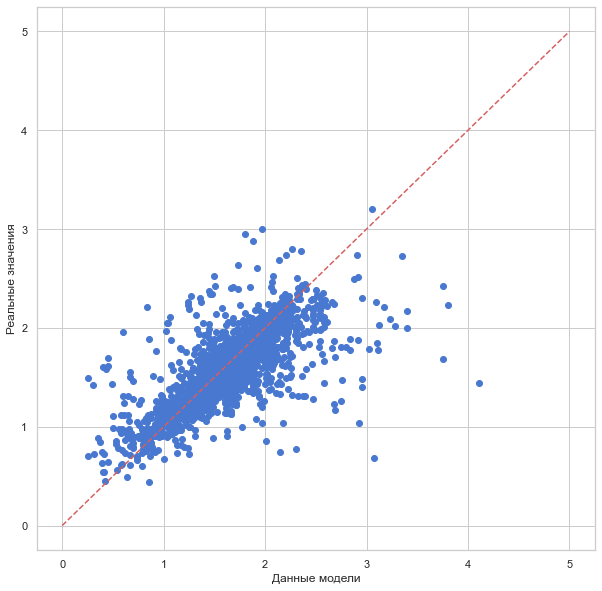

In [12]:
model_score(clf, X_test, y_test)

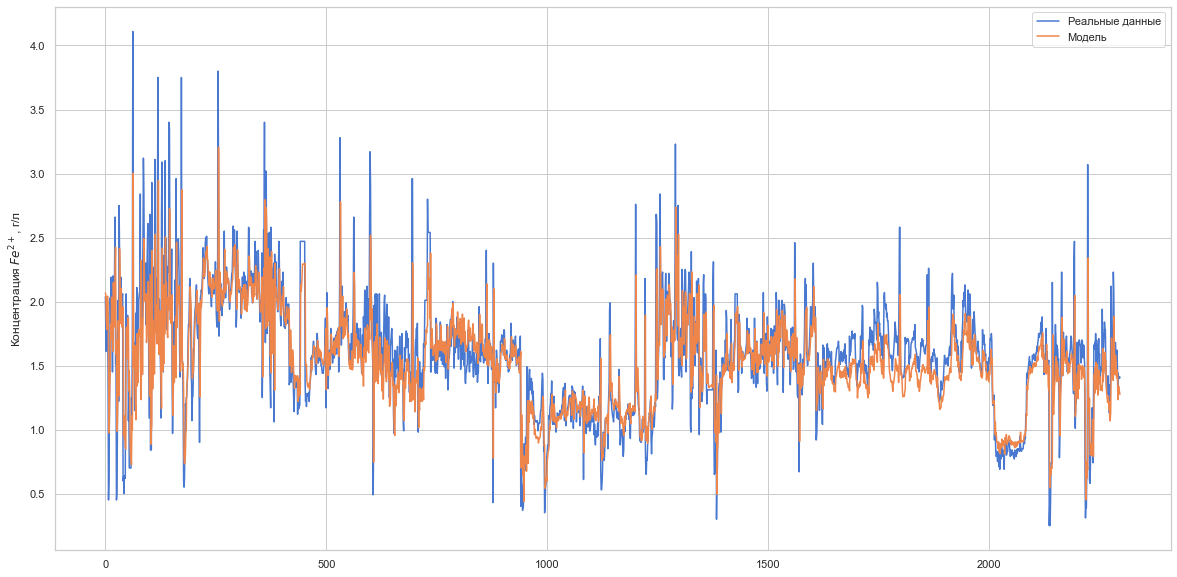

In [13]:
pred = clf.predict(X_test)

plt.figure(figsize=(20,10))

plt.plot(y_test.values, label='Реальные данные')
plt.plot(pred, label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();

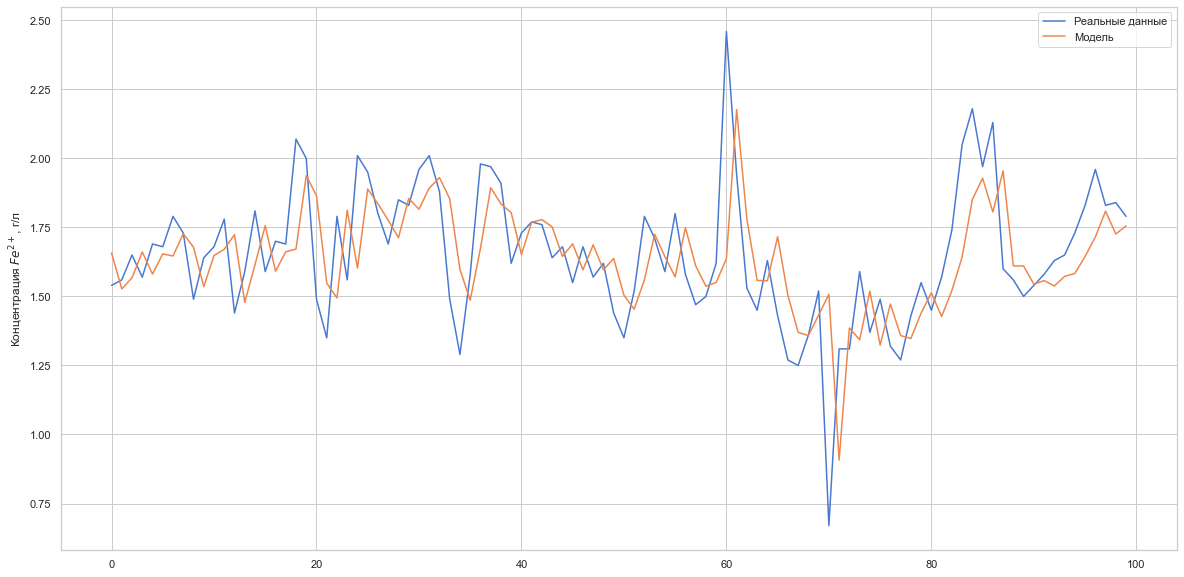

In [14]:
plt.figure(figsize=(20,10))

plt.plot(y_test.values[1500:1600], label='Реальные данные')
plt.plot(pred[1500:1600], label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();

In [15]:
res = permutation_importance(clf, X_train, y_train)

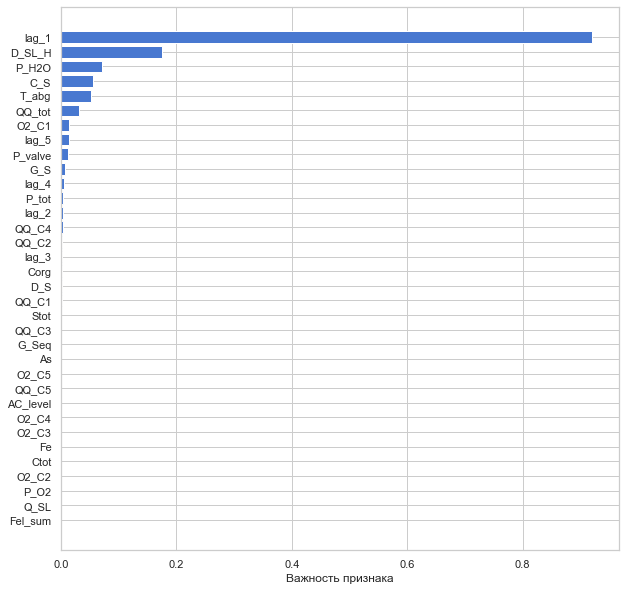

In [16]:
importance = res.importances_mean
sort = importance.argsort()

plt.figure(figsize=(10,10))
plt.barh(X_test.columns[sort], importance[sort])
plt.xlabel("Важность признака")
plt.show();

Модель только на сдвигах (1-5 часов)

In [17]:
X_train_short = X_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
X_test_short = X_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]

Метрики качества
RMSE: 0.2937
MAE: 0.1700
R2: 0.5736


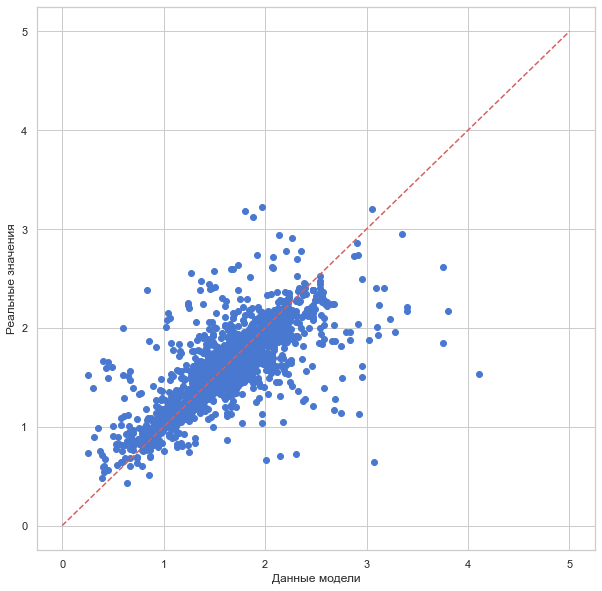

In [18]:
clf.fit(X_train_short, y_train)
model_score(clf, X_test_short, y_test)

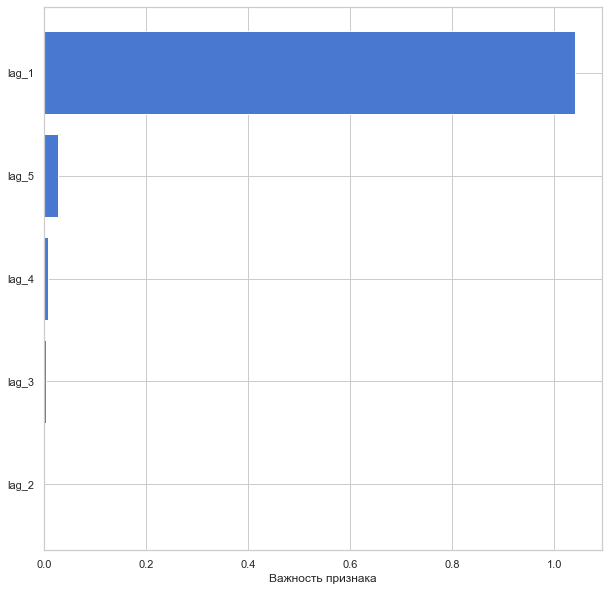

In [19]:
res_table = permutation_importance(clf, X_train_short, y_train)

importance = res_table.importances_mean
sort = importance.argsort()

plt.figure(figsize=(10,10))
plt.barh(X_test_short.columns[sort], importance[sort])
plt.xlabel("Важность признака")
plt.show();

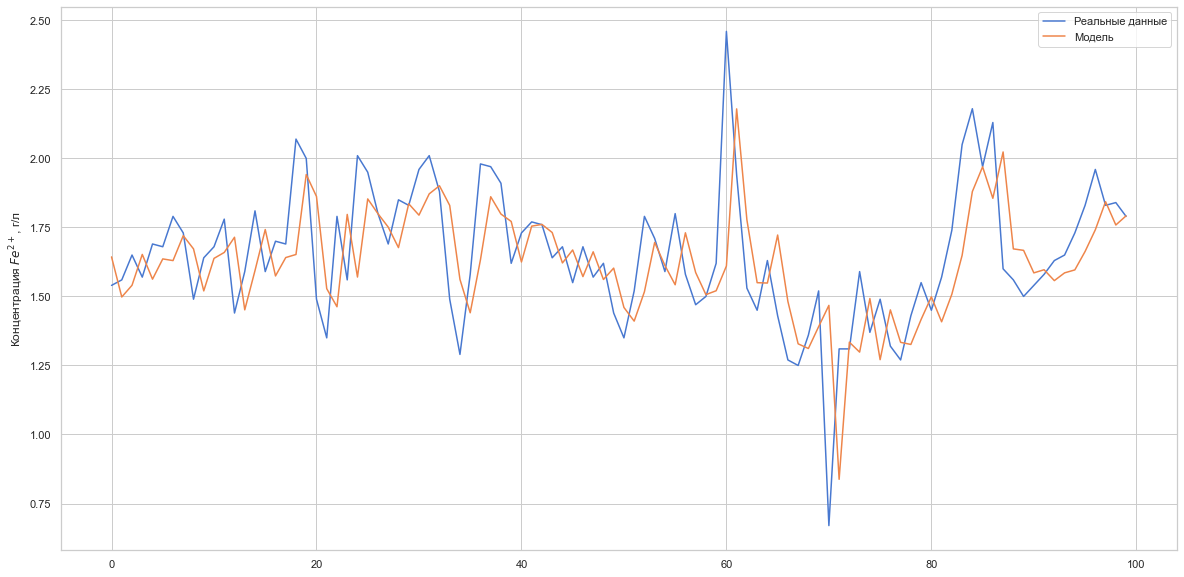

In [21]:
clf.fit(X_train_short, y_train)
pred_short = clf.predict(X_test_short)

plt.figure(figsize=(20,10))

plt.plot(y_test.values[1500:1600], label='Реальные данные')
plt.plot(pred_short[1500:1600], label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();

Оценки автокоррелиции ряда

In [52]:
import statsmodels.api as sm

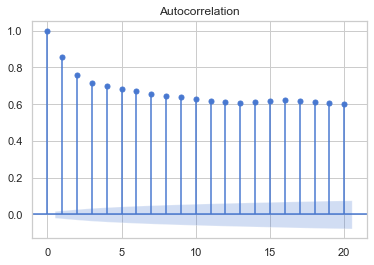

In [57]:
sm.graphics.tsa.plot_acf(y, lags=20)
plt.show()

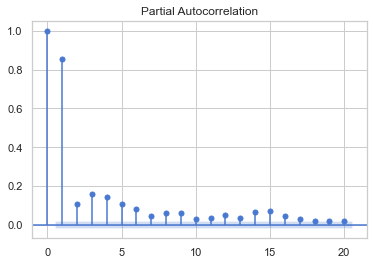

In [59]:
sm.graphics.tsa.plot_pacf(y, lags=20)
plt.show()

Модель только на табличных данных без сдвига и перемешивания

In [22]:
X_train_table = X_train.drop(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'], axis=1)
X_test_table = X_test.drop(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'], axis=1)

Метрики качества
RMSE: 0.6386
MAE: 0.4941
R2: -1.0159


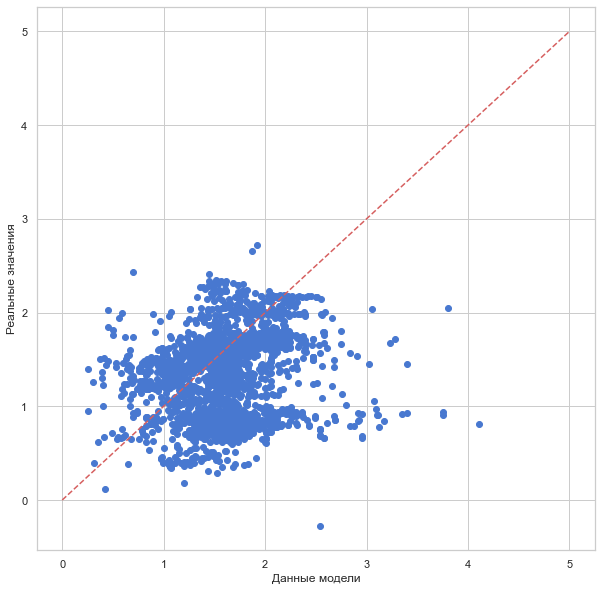

In [23]:
clf.fit(X_train_table, y_train)
model_score(clf, X_test_table, y_test)

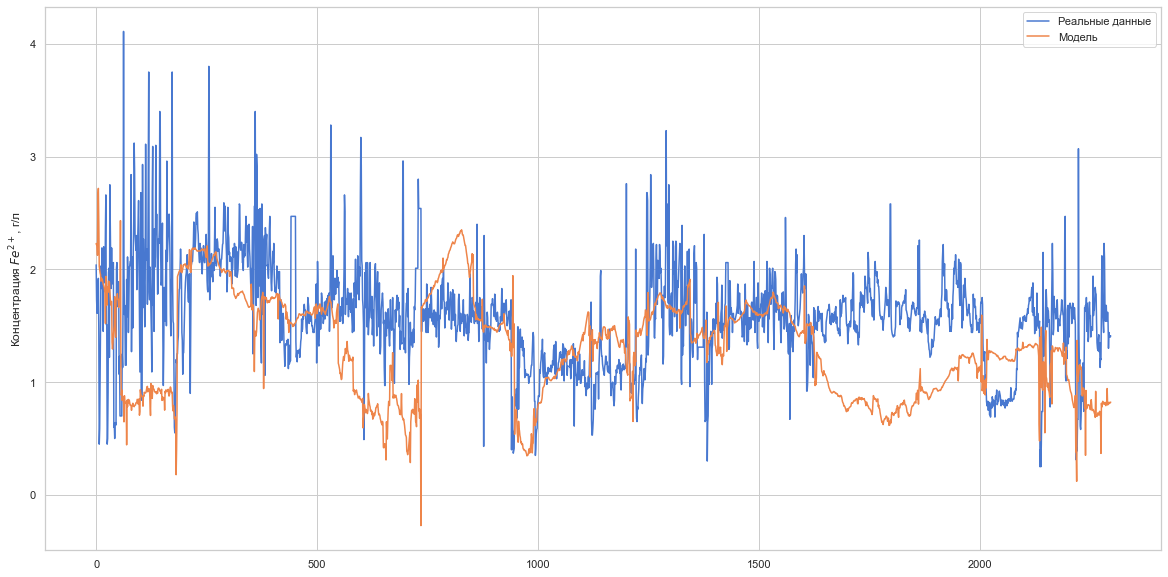

In [26]:
pred_table = clf.predict(X_test_table)

plt.figure(figsize=(20,10))

plt.plot(y_test.values, label='Реальные данные')
plt.plot(pred_table, label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();

Модель на всех данных с перемешиванием

Метрики качества
RMSE: 0.2629
MAE: 0.1560
R2: 0.7604


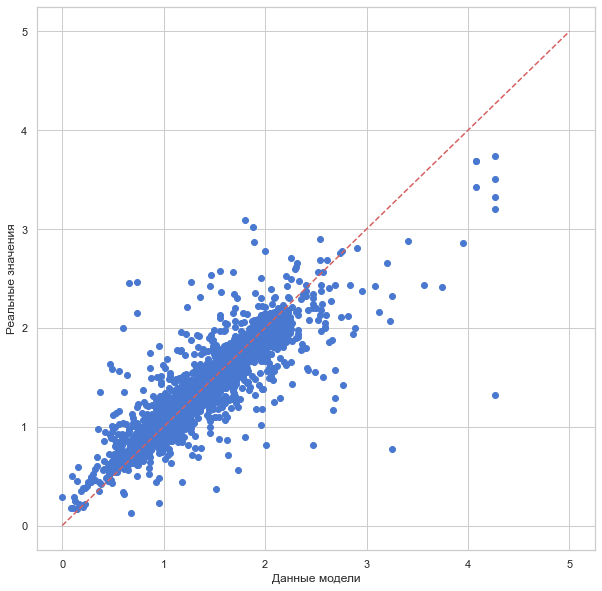

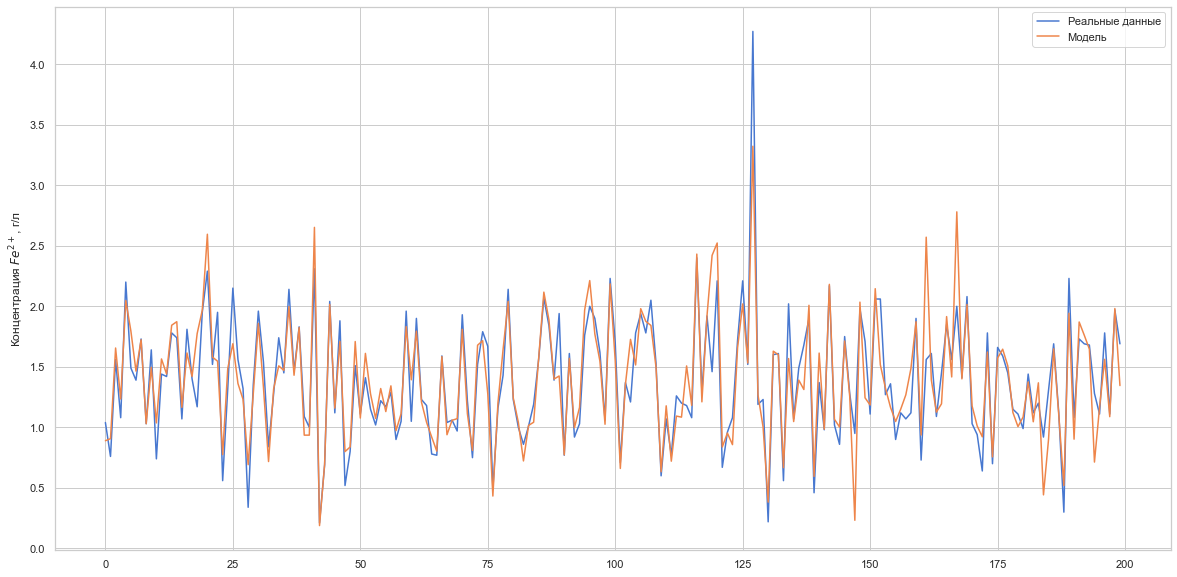

In [34]:
X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

clf.fit(X_train_sh, y_train_sh)
model_score(clf, X_test_sh, y_test_sh)


pred_sh = clf.predict(X_test_sh)

plt.figure(figsize=(20,10))

plt.plot(y_test_sh.values[0:200], label='Реальные данные')
plt.plot(pred_sh[0:200], label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();

Модель на табличных данных с перемешиванием

Метрики качества
RMSE: 0.4074
MAE: 0.2866
R2: 0.4245


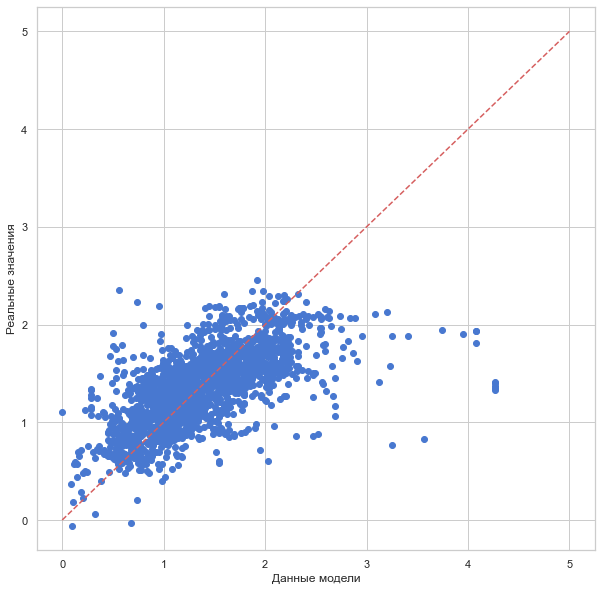

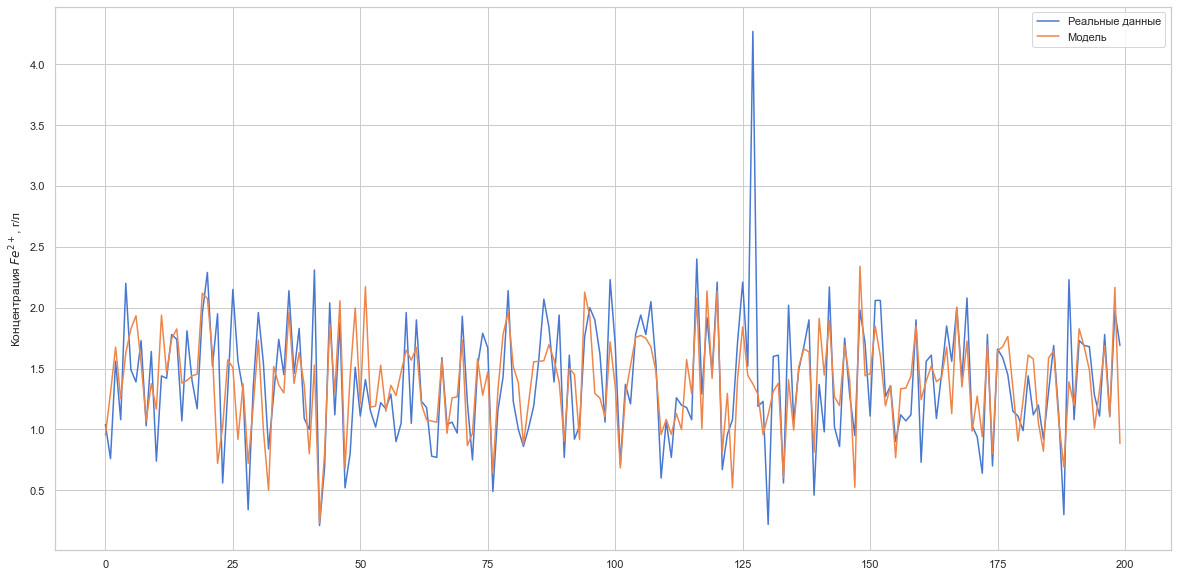

In [35]:
X_train_table_sh = X_train_sh.drop(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'], axis=1)
X_test_table_sh = X_test_sh.drop(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'], axis=1)

clf.fit(X_train_table_sh, y_train_sh)
model_score(clf, X_test_table_sh, y_test_sh)


pred_table_sh = clf.predict(X_test_table_sh)

plt.figure(figsize=(20,10))

plt.plot(y_test_sh.values[0:200], label='Реальные данные')
plt.plot(pred_table_sh[0:200], label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();

Настройки кросс-валидации

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

In [41]:
tscv = TimeSeriesSplit(n_splits=5)

cv_res = cross_validate(
    clf,
    X, y,
    cv = tscv,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
)

mae = -cv_res['test_neg_mean_absolute_error'].mean()
rmse = -cv_res['test_neg_root_mean_squared_error'].mean()
r2 = cv_res['test_r2'].mean()

print(mae, rmse, r2)

0.18335426627647686 0.28186908458413107 0.4386558064133562


In [42]:
cv_res = cross_validate(
    clf,
    X.drop(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'], axis=1), 
    y,
    cv = tscv,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
)

mae = -cv_res['test_neg_mean_absolute_error'].mean()
rmse = -cv_res['test_neg_root_mean_squared_error'].mean()
r2 = cv_res['test_r2'].mean()

print(mae, rmse, r2)

0.4275138598313954 0.536715396702322 -0.9977252043412225


Модель все данные, перемешивание, удаление индекса

In [96]:
X_reset = X.reset_index().drop(['index'], axis=1)

Метрики качества
RMSE: 0.1426
MAE: 0.0988
R2: 0.9109


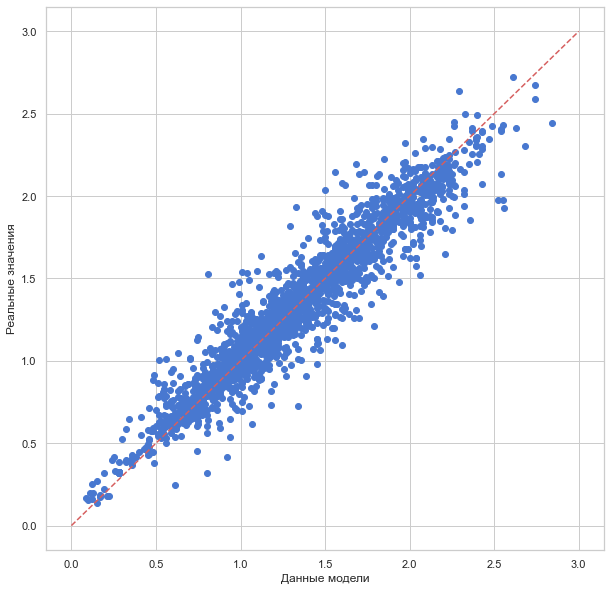

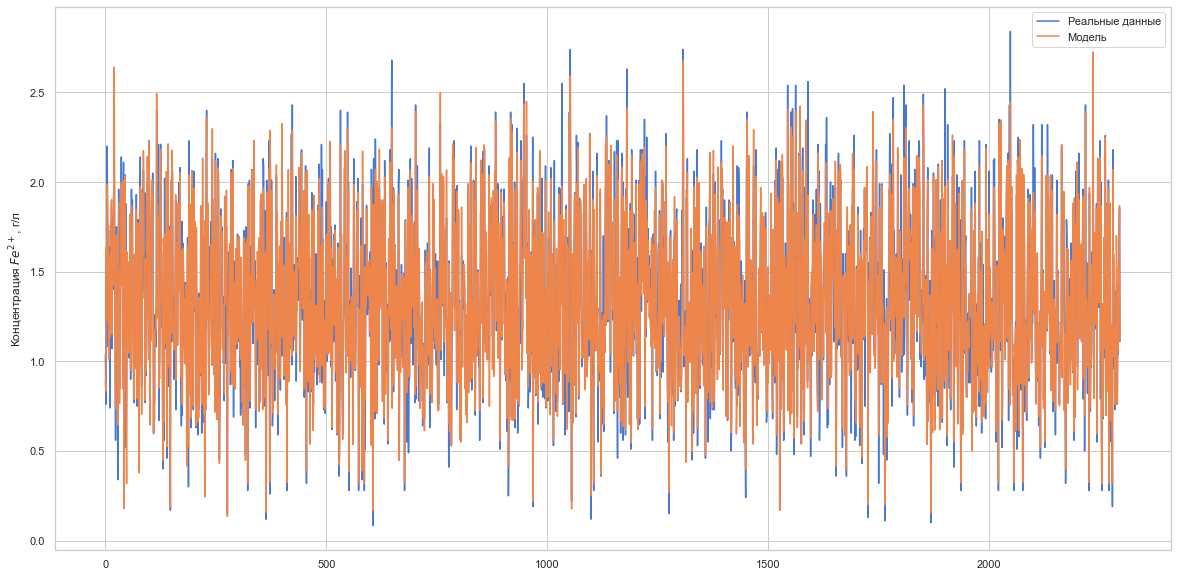

In [98]:
X_train_reset, X_test_reset, y_train_reset, y_test_reset = train_test_split(X_reset, y, test_size = 0.2, random_state=42, shuffle=True)

clf.fit(X_train_reset, y_train_reset)
model_score(clf, X_test_reset, y_test_reset)


pred_reset = clf.predict(X_test_reset)

plt.figure(figsize=(20,10))

plt.plot(y_test_reset.values, label='Реальные данные')
plt.plot(pred_reset, label='Модель')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")

plt.legend()
plt.show();